In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10

from tensorflow.keras.layers import Layer, Dense, Input, Dropout, BatchNormalization, LeakyReLU, Lambda
from tensorflow.keras.layers import Subtract, Add, MaxPooling2D, LayerNormalization
from tensorflow.keras.initializers import RandomNormal, RandomUniform, GlorotNormal, Constant, GlorotUniform
from tensorflow.keras.constraints import Constraint, NonNeg
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1_l2, l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import Loss

from tensorflow.keras.layers import Reshape, Conv2D, Flatten, Conv1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.io import loadmat
import tikzplotlib

from bayes_opt import BayesianOptimization
from itertools import combinations

import math
import os                          
import random as rn
import gc                          

# Dataset

## Benchmark

In [2]:
class Dataset():
    def __init__(self, name=None):
        self.name = name
        self.datasets = None

    def load_data(self, normalize=True, **kwargs):
        if self.name == 'mnist':
            (x_train, y_train), (x_test, y_test) = mnist.load_data()
            x_train = (np.reshape(x_train, newshape=(len(x_train), -1)) / 255).astype(np.float32)
            y_train = y_train.astype(np.float32)
            x_test = (np.reshape(x_test, newshape=(len(x_test), -1)) / 255).astype(np.float32)
            y_test = y_test.astype(np.float32)
        else:
            raise ValueError('Please enter a valid realtion mode...')

        self.x_train, self.y_train, self.x_test, self.y_test = x_train, y_train, x_test, y_test
        self.input_shape = x_train.shape[1:]
        return x_train, y_train, x_test, y_test


# FeatureSelectionLayer:

In [3]:
def mu_regularizer(x):
    sigma = 0.5
    inner = (x+0.5)/sigma
    reg = tf.reduce_mean(0.5 * (1 + tf.math.erf(inner/math.sqrt(2))))
    return reg


class FeatureSelector(Layer):       
    def __init__(self, input_dim, lam, sigma, **kwargs):
        #param kwargs: The name of this layer.

        super(FeatureSelector, self).__init__(**kwargs)
        self.sigma = sigma
        self.lam = lam
        self.num_fea = input_dim
        
    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(self.num_fea, ),
                                  initializer=RandomNormal(stddev=1e-4),
                                  regularizer=mu_regularizer,
                                  trainable=True)
        
    def call(self, prev_x):
        z = self.mu + self.sigma * np.random.randn(self.num_fea)
        stochastic_gate = tf.clip_by_value(z+0.5, 0.0, 1.0)            # set mu=0.5 at very first beginning
        new_x = prev_x * stochastic_gate
        
        return new_x              
    
    #def get_support()

# HiddenNetwork

In [4]:
def get_HiddenModel(input_dim, output_dim, hidden_dims, task):

    if hidden_dims is None:
        hidden_dims = []
    elif type(hidden_dims) is int:
        hidden_dims = [hidden_dims]
    dims = [input_dim]
    dims.extend(hidden_dims)
    dims.append(output_dim)
    model = keras.Sequential(name="MLP_Learning")

    nr_hiddens = len(hidden_dims)
    for i in range(nr_hiddens):
        model.add(Dense(dims[i+1], activation="relu"))      
    
    if task in ['regression']:
        model.add(Dense(output_dim, activation="linear", name='regression'))
    elif task in ['classification']:
        model.add(Dense(output_dim, activation="softmax", name='classification'))
    else:
        raise ValueError ('Please enter a valid laearning task!')

    return model

# Followings are for wrapping out the whole model:

# =============================================================

# STG：

In [5]:
class STG():

    def __init__(self, task="classification", input_dim=None, output_dim=None, hidden_dims=[60,20],
                 learning_rate=0.1, lam=0.5, sigma=0.5, **kwargs):  

        self.task = task
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dims = hidden_dims
        self.learning_rate = learning_rate
        self.lam = lam
        self.sigma = sigma
        self.optimizer = Adam(learning_rate=self.learning_rate, decay=1e-9)

        # ---------- define feature selection models ----------
        input_layer = Input(shape=self.input_dim, name="InputLayer")    
        
        selection_network = FeatureSelector(input_dim=self.input_dim, lam=self.lam, sigma=self.sigma, name="FS", **kwargs )  
        hiddenModel = get_HiddenModel(input_dim=self.input_dim, output_dim=self.output_dim, hidden_dims=self.hidden_dims, task=self.task)

        x = selection_network(input_layer)           
        output_layer = hiddenModel(x)                 

        self.fs_wrapper = Model(inputs=input_layer, outputs=output_layer)    
        self.selection_net = Model(inputs=input_layer, outputs=x)           
        self.learning_net =hiddenModel                                     
        

        if task in ['classification']:
            loss = 'sparse_categorical_crossentropy'
            metrics = ['accuracy']
        elif task in ['regression', 'unsupervised']:
            loss = 'mse'
            metrics = None
        else:
            raise ValueError('Please enter valid losses and metrics...')


        
        
        self.fs_wrapper.compile(optimizer=self.optimizer, loss=loss, metrics=metrics)    
        self.selection_net.compile('sgd', 'mse', metrics)                
        self.learning_net.compile('sgd', 'mse', metrics)        

    def fit(self, x=None, y=None, **kwargs):
        self.hist = self.fs_wrapper.fit(x=x, y=y, **kwargs)       
        return self.hist

# Experiments

In [6]:
dataset = Dataset(name='mnist')
data = dataset.load_data()
model = STG(task="classification", 
            input_dim=data[0].shape[1], 
            output_dim=10, 
            hidden_dims=[128,64,16],
            learning_rate=1e-3, 
            lam=0.5, 
            sigma=0.5)

In [7]:
model.fit(x=data[0],
          y=data[1],
          batch_size=512, 
          epochs=70,
          verbose=1)

Epoch 1/70
118/118 [==============================] - 0s 4ms/step - loss: 1.7251 - accuracy: 0.7265
Epoch 2/70
118/118 [==============================] - 1s 4ms/step - loss: 1.0470 - accuracy: 0.9211
Epoch 3/70
118/118 [==============================] - 1s 4ms/step - loss: 0.9168 - accuracy: 0.9412
Epoch 4/70
118/118 [==============================] - 0s 4ms/step - loss: 0.8113 - accuracy: 0.9507
Epoch 5/70
118/118 [==============================] - 1s 4ms/step - loss: 0.7174 - accuracy: 0.9582
Epoch 6/70
118/118 [==============================] - 0s 4ms/step - loss: 0.6372 - accuracy: 0.9633
Epoch 7/70
118/118 [==============================] - 1s 4ms/step - loss: 0.5668 - accuracy: 0.9668
Epoch 8/70
118/118 [==============================] - 0s 4ms/step - loss: 0.5112 - accuracy: 0.9696
Epoch 9/70
118/118 [==============================] - 0s 4ms/step - loss: 0.4641 - accuracy: 0.9718
Epoch 10/70
118/118 [==============================] - 0s 4ms/step - loss: 0.4271 - accuracy: 0.9743

# Mask visualization

In [8]:
mu = model.selection_net.layers[-1].mu.numpy()

In [9]:
z = mu + 0.5 * np.random.randn(784, )
mask = tf.clip_by_value(z+0.5, 0.0, 1.0)

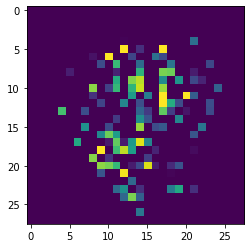

In [10]:
plt.imshow(mask.numpy().reshape(28, 28))

In [11]:
mask.numpy()

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     